In [1]:
from time import time
from sklearn.cluster import k_means
from elm import ELMClassifier, ELMRegressor, GenELMClassifier, GenELMRegressor
from random_layer import RandomLayer, MLPRandomLayer, RBFRandomLayer, GRBFRandomLayer
from sklearn.neighbors import KDTree
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [1]:
import pandas as pd
import numpy as np
#dataset link: http://climate.weather.gc.ca/
data = pd.read_csv('winter_processed.csv')
data = np.array(data)
data

array([[ 7],
       [ 0],
       [15],
       ..., 
       [17],
       [20],
       [30]])

In [3]:
#This is to convert Time Series to 0-mean and unit-std deviation series.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(data)

/home/akshay/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
from sklearn.cross_validation import train_test_split

scaler.mean_
scaler.scale_
data_scaled = scaler.transform(data)
#splitting data into test and train parts
d_train,d_test = train_test_split(data_scaled, test_size=0.2, random_state=42)

/home/akshay/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
#memory order
m = 16
#auto corrected input vector for training (we are taking 16 lagged values as features for each data point)
x_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[16][0])

for i in range(1,1135):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    x_train = np.vstack([x_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
    
#auto corrected input vector for test
x_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[16][0])

for i in range(1,266):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    x_test = np.vstack([x_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])

In [6]:
from sklearn import pipeline
import matplotlib.pyplot as plt
#parameters
n_hidden = 500
alpha = 0.7
rbf_width = 0.1
activation_func = 'sigmoid'
regressor = None
random_state = 0
ridge_alpha = 0.001
rl = RandomLayer( n_hidden = n_hidden, alpha = alpha, 
    rbf_width = rbf_width, activation_func = activation_func )

ridge = Ridge( alpha = ridge_alpha )

elmr = pipeline.Pipeline( [( 'rl', rl ), ( 'ridge', ridge )] )  

elmr.fit( x_train, y_train )
#p = elmr.predict( x_test )
print ("Training Score: ",elmr.score(x_train, y_train),"Testing Score: ", -elmr.score(x_test, y_test))


Training Score:  0.405893546002 Testing Score:  0.802838717312


In [7]:
err_train = elmr.predict(x_train) - y_train
err_test = elmr.predict(x_test) - y_test

In [8]:
tree = KDTree(x_train,leaf_size=200)
dist, ind = tree.query(x_test,k=150)
print(ind.shape)

(266, 150)


In [9]:
err_dict = np.zeros(shape=(len(x_test),150))
j = 0
for tst_pattern in (ind):
    err_dict[j] = [err_train[i] for i in ind[j]]
    j+=1

In [10]:
U = []
L = []
U = [y_test[i] + max(err_dict[i]) for i in range(len(err_dict))]
L = [y_test[i] + min(err_dict[i]) for i in range(len(err_dict))]

In [11]:
x_test.shape, y_test.shape

((266, 16), (266, 1))

In [12]:
count = 0
i = 0
for val in y_test:
    if val >= L[i] and val <= U[i]:
        count += 1
    i+= 1
picp = count/len(y_test)

In [13]:
y_min = np.amin(y_test)
y_max = np.amax(y_test)
S = 0

for i in range(len(L)):
    S+= (abs(U[i]-L[i]))

S /= (y_max-y_min)

In [14]:
S /= len(y_test)
S

array([ 1.01982448])

In [15]:
print("PICP (Probability Coverage) value: ",picp,"NMPIW (Measure of PI widths) value: ",S)

PICP (Probability Coverage) value:  1.0 NMPIW (Measure of PI widths) value:  [ 1.01982448]


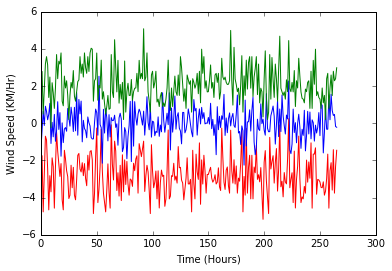

In [19]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(L,'r') # plotting t,a separately 
plt.plot(elmr.predict(x_test),'b') # plotting t,b separately 
plt.plot(U,'g') # plotting t,c separately 
plt.xlabel("Time (Hours)")
plt.ylabel("Wind Speed (KM/Hr)")
plt.show()
